In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import azureml.core
from azureml.core import Workspace, Dataset

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.33.0


In [2]:
classesDF=pd.read_csv("classlabels.csv")
trnDF=pd.read_csv("TRN.csv").merge(classesDF, on="label").drop("label", axis=1)
valDF=pd.read_csv("VAL.csv").merge(classesDF, on="label").drop("label", axis=1)
tstDF=pd.read_csv("TST.csv").merge(classesDF, on="label").drop("label", axis=1)
txnDF=pd.read_csv("TXN.csv").merge(classesDF, on="label").drop("label", axis=1)

In [3]:
X_train_files = trnDF['name'].values
X_validate_files = valDF['name'].values
X_test_files = tstDF['name'].values

In [4]:
# find average size of images
widths = []
heighths = []
all_files = np.hstack((X_train_files, X_validate_files, X_test_files)).ravel()
for image_filename in all_files:
    image = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
    h,w = image.shape # rows, columns
    widths.append(w)
    heighths.append(h)

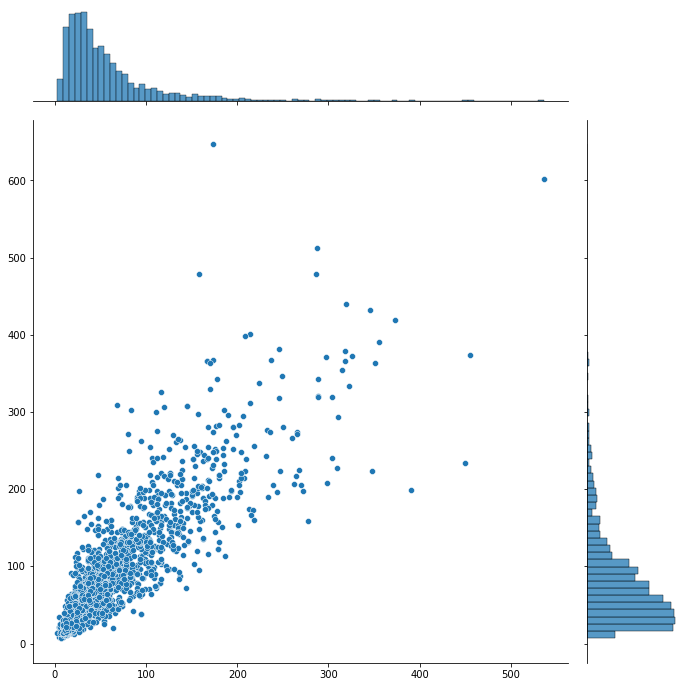

In [33]:
g = sns.jointplot(x=widths, y=heighths)
g.fig.set_figwidth(10)
g.fig.set_figheight(10)

In [6]:
pd.DataFrame({'heighths': heighths, 'widths': widths}).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
heighths,2704.0,81.849852,66.272537,7.0,37.0,63.0,102.0,647.0
widths,2704.0,57.204882,52.608504,3.0,24.0,41.0,69.0,536.0


In [7]:
image_w = 128
image_h = 128
#image_shape = (image_h, image_w, 3)
#color_mode = "rgb"
image_shape = (image_h, image_w, 1)
color_mode = "grayscale"

batch_size = 32

In [8]:
# randomize training image generator to reduce overfitting
training_image_generator = ImageDataGenerator(
    rotation_range=15, # rotate the image up to 15 degrees
    width_shift_range=0.10, # Shift the pic width by a max of 10%
    height_shift_range=0.10, # Shift the pic height by a max of 10%
    rescale=1/255, # Rescale the image by normalzing it.
    shear_range=0.1, # Shear means cutting away part of the image (max 10%)
    zoom_range=0.1, # Zoom in by 10% max
)

In [9]:
# validation and test image generator
vanilla_image_generator = ImageDataGenerator(rescale=1/255)

In [10]:
def make_image_generator(df, x_col='name', y_col='class', directory=os.getcwd(), shuffle=True, image_shape=image_shape, image_generator=vanilla_image_generator):
    return image_generator.flow_from_dataframe(df, x_col=x_col, y_col=y_col, directory=directory,
        target_size=image_shape[:2], color_mode=color_mode,
        class_mode='categorical', batch_size=batch_size, shuffle=shuffle)

In [11]:
train_img_gen = make_image_generator(trnDF, image_generator=training_image_generator)
validate_img_gen = make_image_generator(valDF, shuffle=False)
test_img_gen = make_image_generator(tstDF, shuffle=False)

Found 930 validated image filenames belonging to 62 classes.
Found 844 validated image filenames belonging to 62 classes.
Found 930 validated image filenames belonging to 62 classes.


In [12]:
# Convolutional Neural Network
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(62, activation='softmax'))

#model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.03, decay=1e-4, momentum=0.90, nesterov=True), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       2

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=25)

In [16]:
results = model.fit(train_img_gen, epochs=1000, validation_data=validate_img_gen, batch_size=batch_size, callbacks=[early_stop])

Epoch 1/1000
30/30 [==============================] - 83s 3s/step - loss: 4.1368 - accuracy: 0.0086 - val_loss: 4.1269 - val_accuracy: 0.0178
Epoch 2/1000
30/30 [==============================] - 84s 3s/step - loss: 4.1282 - accuracy: 0.0097 - val_loss: 4.1272 - val_accuracy: 0.0178
Epoch 3/1000
30/30 [==============================] - 83s 3s/step - loss: 4.1278 - accuracy: 0.0140 - val_loss: 4.1282 - val_accuracy: 0.0024
Epoch 4/1000
30/30 [==============================] - 86s 3s/step - loss: 4.1247 - accuracy: 0.0194 - val_loss: 4.1450 - val_accuracy: 0.0036
Epoch 5/1000
30/30 [==============================] - 86s 3s/step - loss: 4.1229 - accuracy: 0.0247 - val_loss: 4.1264 - val_accuracy: 0.0118
Epoch 6/1000
30/30 [==============================] - 91s 3s/step - loss: 4.1146 - acc

In [17]:
model.save("characters.h5")

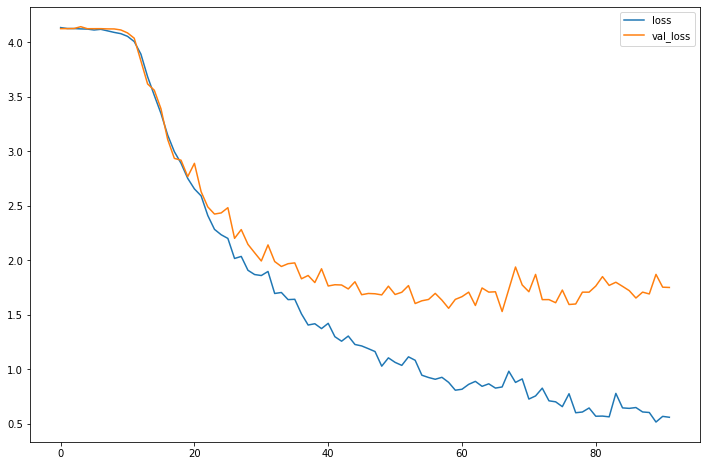

In [18]:
history = pd.DataFrame(model.history.history)
history[['loss','val_loss']].plot(figsize=(12, 8))

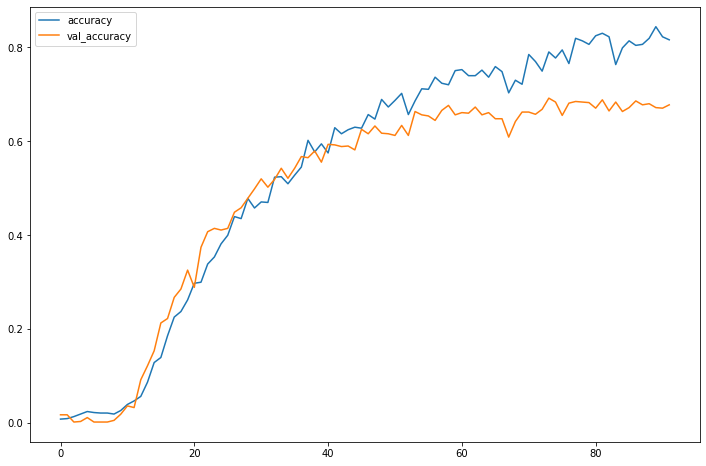

In [19]:
history[['accuracy', 'val_accuracy']].plot(figsize=(12, 8))

In [20]:
history.to_csv("history.csv", index=False)

In [35]:
[val_loss, val_accuracy] = model.evaluate(validate_img_gen)
val_loss, val_accuracy

27/27 [==============================] - 54s 2s/step - loss: 1.7509 - accuracy: 0.6777


(1.7508958578109741, 0.6777251362800598)

In [21]:
[test_loss, test_accuracy] = model.evaluate(test_img_gen)
test_loss, test_accuracy

30/30 [==============================] - 38s 1s/step - loss: 1.8835 - accuracy: 0.6011


(1.8834869861602783, 0.601075291633606)

In [22]:
classes = list(test_img_gen.class_indices.keys())

In [23]:
pred_probabilities = model.predict(test_img_gen)

In [24]:
predictions = np.argmax(pred_probabilities, axis=1)

In [25]:
system = [ classes[p] for p in predictions ]

In [26]:
gold = [ classes[t] for t in test_img_gen.classes ]

In [27]:
print(classification_report(gold, system))

              precision    recall  f1-score   support

           0       0.34      0.67      0.45        15
           1       0.62      0.53      0.57        15
           2       0.87      0.87      0.87        15
           3       0.85      0.73      0.79        15
           4       0.92      0.73      0.81        15
           5       0.58      0.73      0.65        15
           6       0.53      0.67      0.59        15
           7       0.88      1.00      0.94        15
           8       0.73      0.73      0.73        15
           9       0.73      0.53      0.62        15
           A       0.80      0.80      0.80        15
           B       0.54      0.47      0.50        15
           C       0.75      0.40      0.52        15
           D       0.62      0.87      0.72        15
           E       0.63      0.80      0.71        15
           F       0.86      0.80      0.83        15
           G       0.64      0.60      0.62        15
           H       0.69    

In [28]:
print(confusion_matrix(gold, system))

[[10  0  0 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 [ 0  0 13 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  1  6  0]
 [ 0  0  0 ...  0  0  7]]


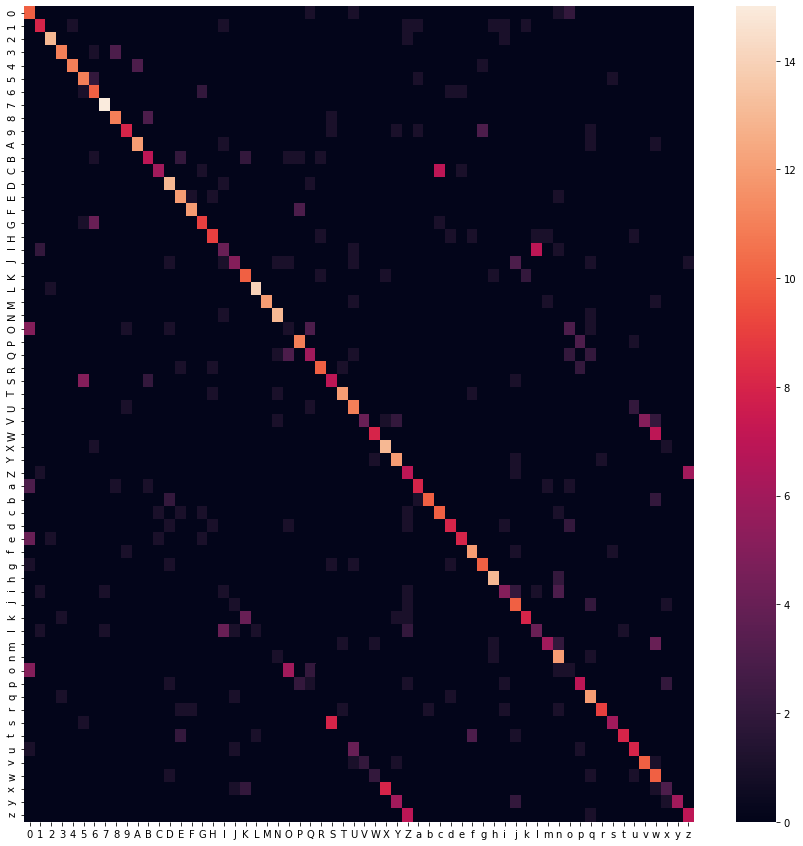

In [29]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(confusion_matrix(gold, system), xticklabels=classes, yticklabels=classes)

In [30]:
import os
import joblib
import json
import logging
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model
from urllib.request import urlopen

In [31]:
# THIS WORKS, BUT SAVES THE FILE

#fname="file.png"
#if os.path.exists(fname):
#  os.remove(fname)
#pth_to_file = get_file(fname=fname, cache_dir=os.getcwd(), cache_subdir="", origin="https://raw.githubusercontent.com/KevinLeeCrosby/characters/main/GoodImg/Bmp/Sample001/img001-00004.png")
#img = load_img(pth_to_file, color_mode=color_mode, target_size=image_shape[:2])
#arr = img_to_array(img)
#arr = np.expand_dims(arr, axis=0)

#pred_probabilities = model.predict(arr)
#prediction = np.argmax(pred_probabilities, axis=1)
#system = [ classes[p] for p in prediction ] # singleton

In [32]:
m = load_model("characters.h5")